In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Vertex AI pipelines imports
from kfp.dsl import (
    Input, 
    Output, 
    Dataset,
    Model,
    Artifact,
    Metrics,
)
from kfp import dsl

## Homework

In this notebook, we reuse the code developed in the [Churn Prediction in Vertex notebook](../theory/02_churn_pred_vertex.ipynb) with our Car Kaggle Dataset. The steps we will follow are:
1. Reusing and modifying the preprocessing/training components.
1. Building a pipeline that leverages [kfp's Parallel looping (dsl.ParallelFor)](https://www.kubeflow.org/docs/components/pipelines/v2/pipelines/control-flow/#parallel-looping-dslparallelfor) to train different models using the *feature elimination* technique.
1. Running the pipeline to compare the models.

`Resulting pipeline:` 
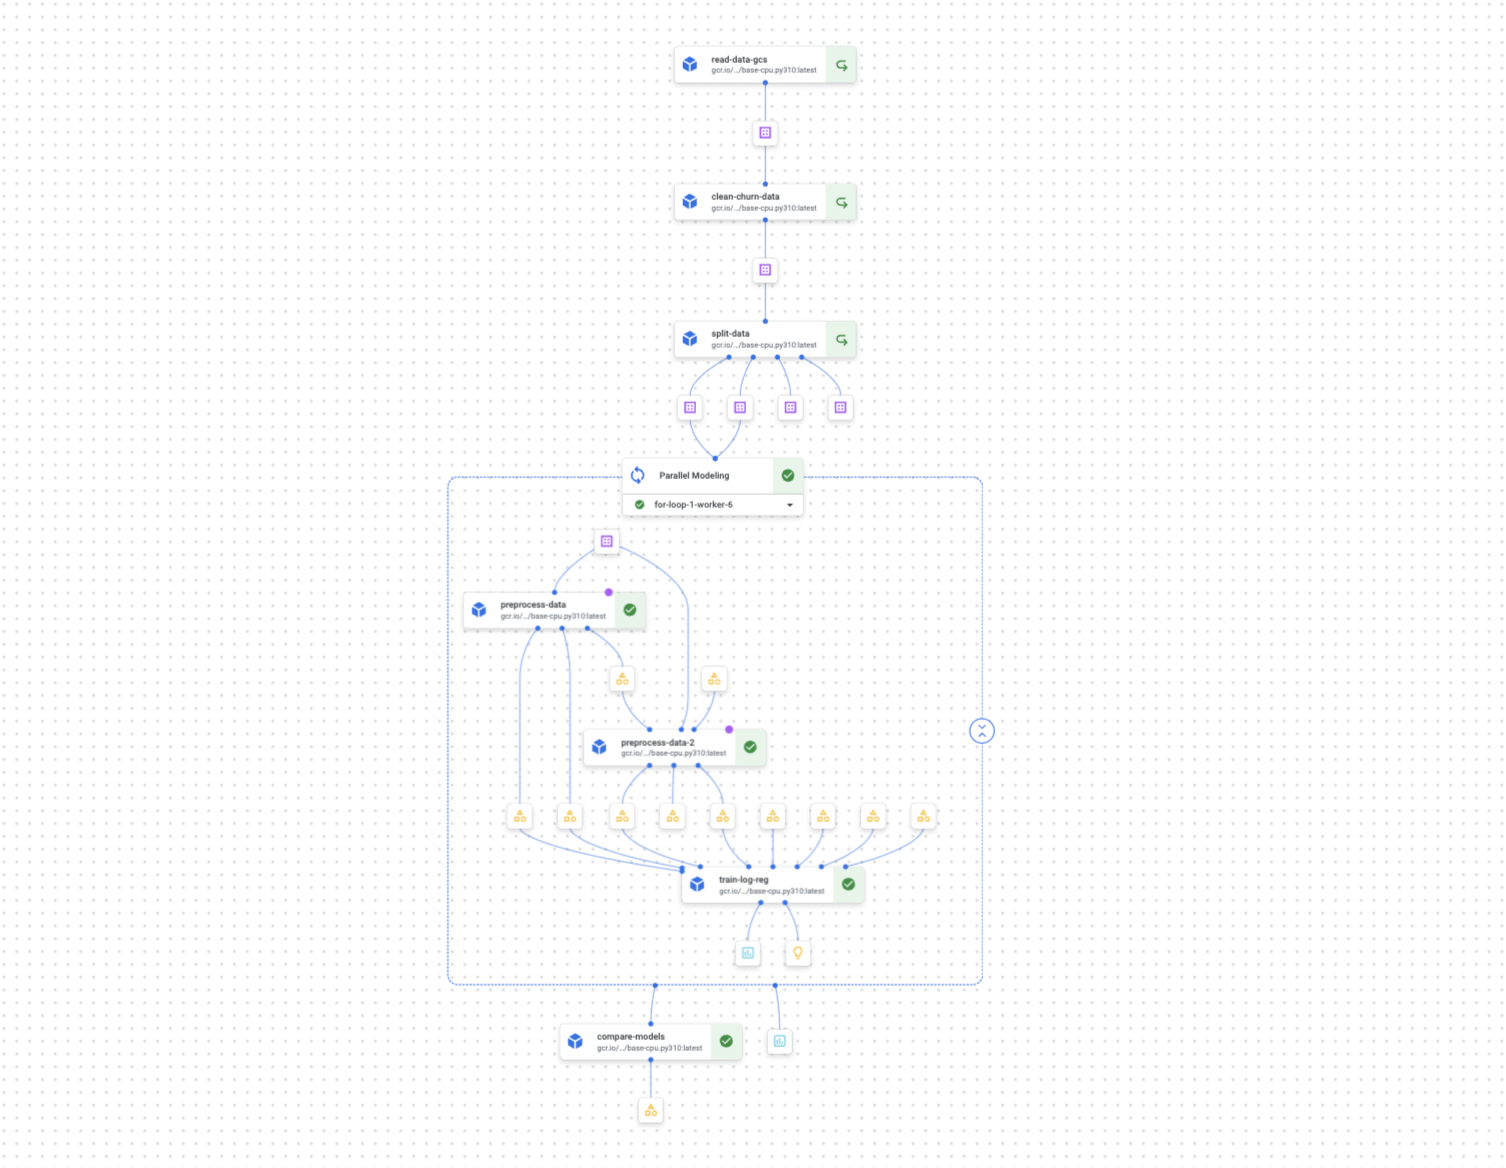

### 1. Preprocessing/Training Components

We want the pipeline to:
* Get the data.

In [ ]:
@dsl.component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install=[
        "gcp_python_client_functions",
    ],
)
def read_data_gcs(
    project_id: str, 
    data_gcs_uri: str,
    out_df: Output[Dataset], 
):
    import pandas as pd
    import pickle
    
    from gcp_python_client_functions.clients import Storage
    ##################### CODE:
    stg_obj = Storage(project_id)

    df = pd.read_csv(data_gcs_uri)

    # Base formatting:
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
    for c in categorical_columns:
        df[c] = df[c].str.lower()

    pd.to_pickle(df, out_df.path + ".pkl")

* Clean the data.
    * Select only the features from above and transform their names.
    * Fill in the missing values of the selected features with 0.
    * Rename `MSRP` variable to `price`.
    * Turn the `price` variable from numeric into a binary format by creating a variable `above_average` which is `1` if the `price` is above its mean value and `0` otherwise.

In [ ]:
@dsl.component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
)
def clean_churn_data(
    in_dataframe: Input[Dataset],
    out_df_prepared: Output[Dataset], 
):
    import pandas as pd
    import numpy as np
    import pickle

    dataframe = pd.read_pickle(in_dataframe.path + ".pkl") 

    df_prepared = dataframe.copy()
    
    # Handle null values
    df_prepared = df_prepared.fillna(0)

    # Binary label (we'll handle the rest of the variables later):
    average = df_prepared.msrp.mean()
    df_prepared['above_average'] = (df_prepared.msrp > average).astype(int)
    df_prepared = df_prepared.rename(columns={"msrp": "price"})

    pd.to_pickle(df_prepared, out_df_prepared.path + ".pkl")

* Split your data in train/val/test sets with 60%/20%/20% distribution (Scikit-Learn `train_test_split` function and set the seed to `42`)

In [ ]:
@dsl.component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
)
def split_data(
    in_df: Input[Dataset],
    out_df_train_full: Output[Dataset], 
    out_df_train: Output[Dataset], 
    out_df_val: Output[Dataset], 
    out_df_test: Output[Dataset],
    test_size: float = 0.2,
    validation_size: float = 0.2,
    random_state: int = 1,
):
    import pandas as pd
    import numpy as np
    import pickle

    from sklearn.model_selection import train_test_split

    df = pd.read_pickle(in_df.path + ".pkl") 
    
    df_train_full, df_test = train_test_split(
        df, 
        test_size=test_size, 
        random_state=random_state,
    )

    # Obtain validation set from the full train:
    train_size = 1 - test_size
    new_validation_size = validation_size/train_size
    
    df_train, df_val = train_test_split(
        df_train_full, 
        test_size=new_validation_size, 
        random_state=random_state,
    )

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    pd.to_pickle(df_train_full, out_df_train_full.path + ".pkl")
    pd.to_pickle(df_train, out_df_train.path + ".pkl")
    pd.to_pickle(df_val, out_df_val.path + ".pkl")
    pd.to_pickle(df_test, out_df_test.path + ".pkl")

* Now, to train a **logistic regression**, we need to prepare our data (get X, y):
    * As in this step we select the columns to use as features, for the next questions we will create a function that generates a dictionary containing the categorical and numerical features we will use to train different models applying the *feature elimination* technique.
    * One-hot encode categorical variables.

In [ ]:
# Create a dictionary with removed features and the rest of them (that will be fed to the models):
def dict_cat_num(categorical, numerical):
    features = numerical + categorical
    n_features = len(features)
    n_cat = len(categorical)
    n_num = len(numerical)
    
    dic = {}
    for i in range(n_features):
        if i < n_cat:
            remove_feature = categorical[i]
            new_categorical = categorical.copy()
            new_categorical.remove(remove_feature)
    
            dic_element = {
            "categorical": new_categorical,
            "numerical": numerical,
            }
        else: 
            j = i - n_cat
            remove_feature = numerical[j]
            new_numerical = numerical.copy()
            new_numerical.remove(remove_feature)
    
            dic_element = {
                "categorical": categorical,
                "numerical": new_numerical,
            }
        dic[remove_feature] = dic_element

    dic['all'] = {
                "categorical": categorical,
                "numerical": numerical,
            }
    return dic

In [ ]:
@dsl.component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def preprocess_data(
    in_dataframe: Input[Dataset],
    dict_features: dict, # here we will receive the result of *dict_cat_num*
    key_feature: str, # here we will receive a key to select a set of categorical and numerical variables from *dict_features*
    label: str,
    out_X: Output[Artifact], 
    out_y: Output[Artifact], 
    out_mct: Output[Artifact],
    fit: bool = True,
    in_mct: Input[Artifact] = None,
) -> str:
    
    import pandas as pd 
    import numpy as np
    import pickle

    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import make_column_transformer

    dataframe = pd.read_pickle(in_dataframe.path + ".pkl") 

    cat_features = dict_features[key_feature]['categorical']
    num_features = dict_features[key_feature]['numerical']
    
    y = dataframe[label]
    dataframe = dataframe[cat_features + num_features].copy()
    
    if fit:
        ohe = OneHotEncoder(
            sparse=False, # Will return sparse matrix if set True
            handle_unknown='ignore' # Whether to raise an error or ignore
        ) 
        mct = make_column_transformer(
            (ohe, cat_features),
            remainder='passthrough',
        )
        X = mct.fit_transform(dataframe)
    else:
        with open(in_mct.path + '.pkl', 'rb') as f:
            mct = pickle.load(f)
        X = mct.transform(dataframe)

    with open(out_X.path+'.pkl', 'wb') as f:
        pickle.dump(X, f)
    with open(out_y.path+'.pkl', 'wb') as f:
        pickle.dump(y, f)
    with open(out_mct.path+'.pkl', 'wb') as f:
        pickle.dump(mct, f)

    return key_feature

* Fit the model on the training dataset.
    - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
    - `model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)`
* Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

In [ ]:
@dsl.component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
    packages_to_install = ["scikit-learn==1.3.1"],
)
def train_log_reg(
    in_X_train: Input[Artifact], 
    in_y_train: Input[Artifact],
    in_X_val: Input[Artifact],
    in_y_val: Input[Artifact],
    out_model: Output[Model], 
    out_metrics: Output[Metrics],
    threshold: float = 0.5,
) -> float:
    import pandas as pd 
    import numpy as np
    import pickle

    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import confusion_matrix

    from google.cloud import aiplatform

    with open(in_X_train.path + '.pkl', 'rb') as f:
        X_train = pickle.load(f)
    with open(in_y_train.path + '.pkl', 'rb') as f:
        y_train = pickle.load(f)
    with open(in_X_val.path + '.pkl', 'rb') as f:
        X_val = pickle.load(f)
    with open(in_y_val.path + '.pkl', 'rb') as f:
        y_val = pickle.load(f)

    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model.fit(X_train, y_train)

    y_pred_val = model.predict_proba(X_val)[:,1]
    churn_decision_val = (y_pred_val >= threshold)

    val_accuracy = (churn_decision_val == y_val).mean()

    with open(out_model.path+'.pkl', 'wb') as f:
        pickle.dump(model, f)

    # log accuracy:
    accuracy = round(val_accuracy, 2)
    out_metrics.log_metric("accuracy", accuracy)

    return accuracy

* Our last component will be used to collect the accuracy of all of the models run in parallel and save them in a dataframe.

In [ ]:
# Collect training results
@dsl.component(
    base_image="gcr.io/deeplearning-platform-release/base-cpu.py310:latest",
)
def compare_models(
    metrics: list, 
    key_features: list, 
    out_df_accuracy: Output[Artifact],
):
    import pandas as pd
    
    d = {'accuracy': metrics, 'key_feature': key_features}
    df = pd.DataFrame(d)

    pd.to_pickle(df, out_df_accuracy.path + ".pkl")

### 2. Building Pipeline (with Parallelization)

With modification to run parallel components with different features for model training (applying *feature elimination* technique).

In [ ]:
@dsl.pipeline(
    name = "pipeline-log-reg-hw-compare",
)
def pipeline(
    project_id: str, 
    data_gcs_uri: str,
    dict_features: dict,
    features: list,
    label: str,
):    
    o1 = read_data_gcs(
        project_id = project_id, 
        data_gcs_uri = data_gcs_uri,
    )
    o2 = clean_churn_data(
        in_dataframe = o1.outputs["out_df"],
    )
    o3 = split_data(
        in_df = o2.outputs["out_df_prepared"],
        random_state = 42,
    )
    parallel_modeling_feature = dsl.ParallelFor(features, "Parallel Modeling")
    with parallel_modeling_feature as feature:
        o4_train = preprocess_data(
            in_dataframe = o3.outputs["out_df_train"],
            dict_features = dict_features,
            key_feature = feature,
            label = label,
        )
        o4_val = preprocess_data(
            in_dataframe = o3.outputs["out_df_val"],
            dict_features = dict_features,
            key_feature = feature,
            label = label,
            fit = False,
            in_mct = o4_train.outputs["out_mct"],
        )
        o5 = train_log_reg(
            in_X_train = o4_train.outputs["out_X"],
            in_y_train = o4_train.outputs["out_y"],
            in_X_val = o4_val.outputs["out_X"],
            in_y_val = o4_val.outputs["out_y"],
        )

    accuracies = dsl.Collected(o5.outputs["Output"])
    key_features = dsl.Collected(o4_train.outputs["Output"])

    compare_models(
        metrics = accuracies, 
        key_features = key_features,
    )

### 3. Vertex Pipeline Run

In [ ]:
import os

from datetime import datetime
import pytz

from kfp import compiler
from google.cloud import aiplatform

from dotenv import load_dotenv
load_dotenv()

# Variables:
PROJECT_ID=os.getenv('PROJECT_ID')
BUCKET_NAME=os.getenv('BUCKET_NAME')
USER=os.getenv('USER')
LOCATION=os.getenv('LOCATION')
SERVICE_ACCOUNT=os.getenv('SERVICE_ACCOUNT')
TEMPLATE_JSON_PATH_LOCAL="pipeline.json"

tz = pytz.timezone("US/Eastern")
EXECUTION_TS = datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S")
DISPLAY_NAME = "pipeline-log-reg-hw-compare-{}".format(EXECUTION_TS)
PIPELINE_ROOT = "gs://{}/02_churn_prediction/pipeline_root_hw".format(BUCKET_NAME)


# Input parameters:
data_gcs_uri = f"gs://{BUCKET_NAME}/01_linear_regression/data.csv"

# Compiling:
compiler.Compiler().compile(
        pipeline_func=pipeline, package_path=TEMPLATE_JSON_PATH_LOCAL
)

In [ ]:
# Create a dictionary with removed features and the rest of them (that will be fed to the models):
numerical = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']
categorical = ['make', 'model', 'year', 'transmission_type', 'vehicle_style']
label = 'above_average'

dic_iter = dict_cat_num(categorical, numerical)

In [ ]:
# Running:
job = aiplatform.PipelineJob(
        display_name=DISPLAY_NAME,
        template_path=TEMPLATE_JSON_PATH_LOCAL,
        pipeline_root=PIPELINE_ROOT,
        enable_caching=True,
        project=PROJECT_ID,
        location=LOCATION,
        labels={"user": USER},
        parameter_values={
            "project_id": PROJECT_ID, 
            "data_gcs_uri": data_gcs_uri,
            "dict_features": dic_iter,
            "features": numerical + categorical + ["all"],
            "label": label,
        },
)

job.submit(service_account=SERVICE_ACCOUNT)

Creating PipelineJob
PipelineJob created. Resource name: projects/532579765435/locations/us-central1/pipelineJobs/pipeline-log-reg-hw-compare-20231002223134
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/532579765435/locations/us-central1/pipelineJobs/pipeline-log-reg-hw-compare-20231002223134')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/pipeline-log-reg-hw-compare-20231002223134?project=532579765435


### Homework Questions

Now, let's go to the homework questions. You will see how easy it is to interact with pipeline artifacts. For example, first, let's interact with the resulting dataset after cleaning and dataprep. We can obtain the link to the model artifact in the Vertex console.

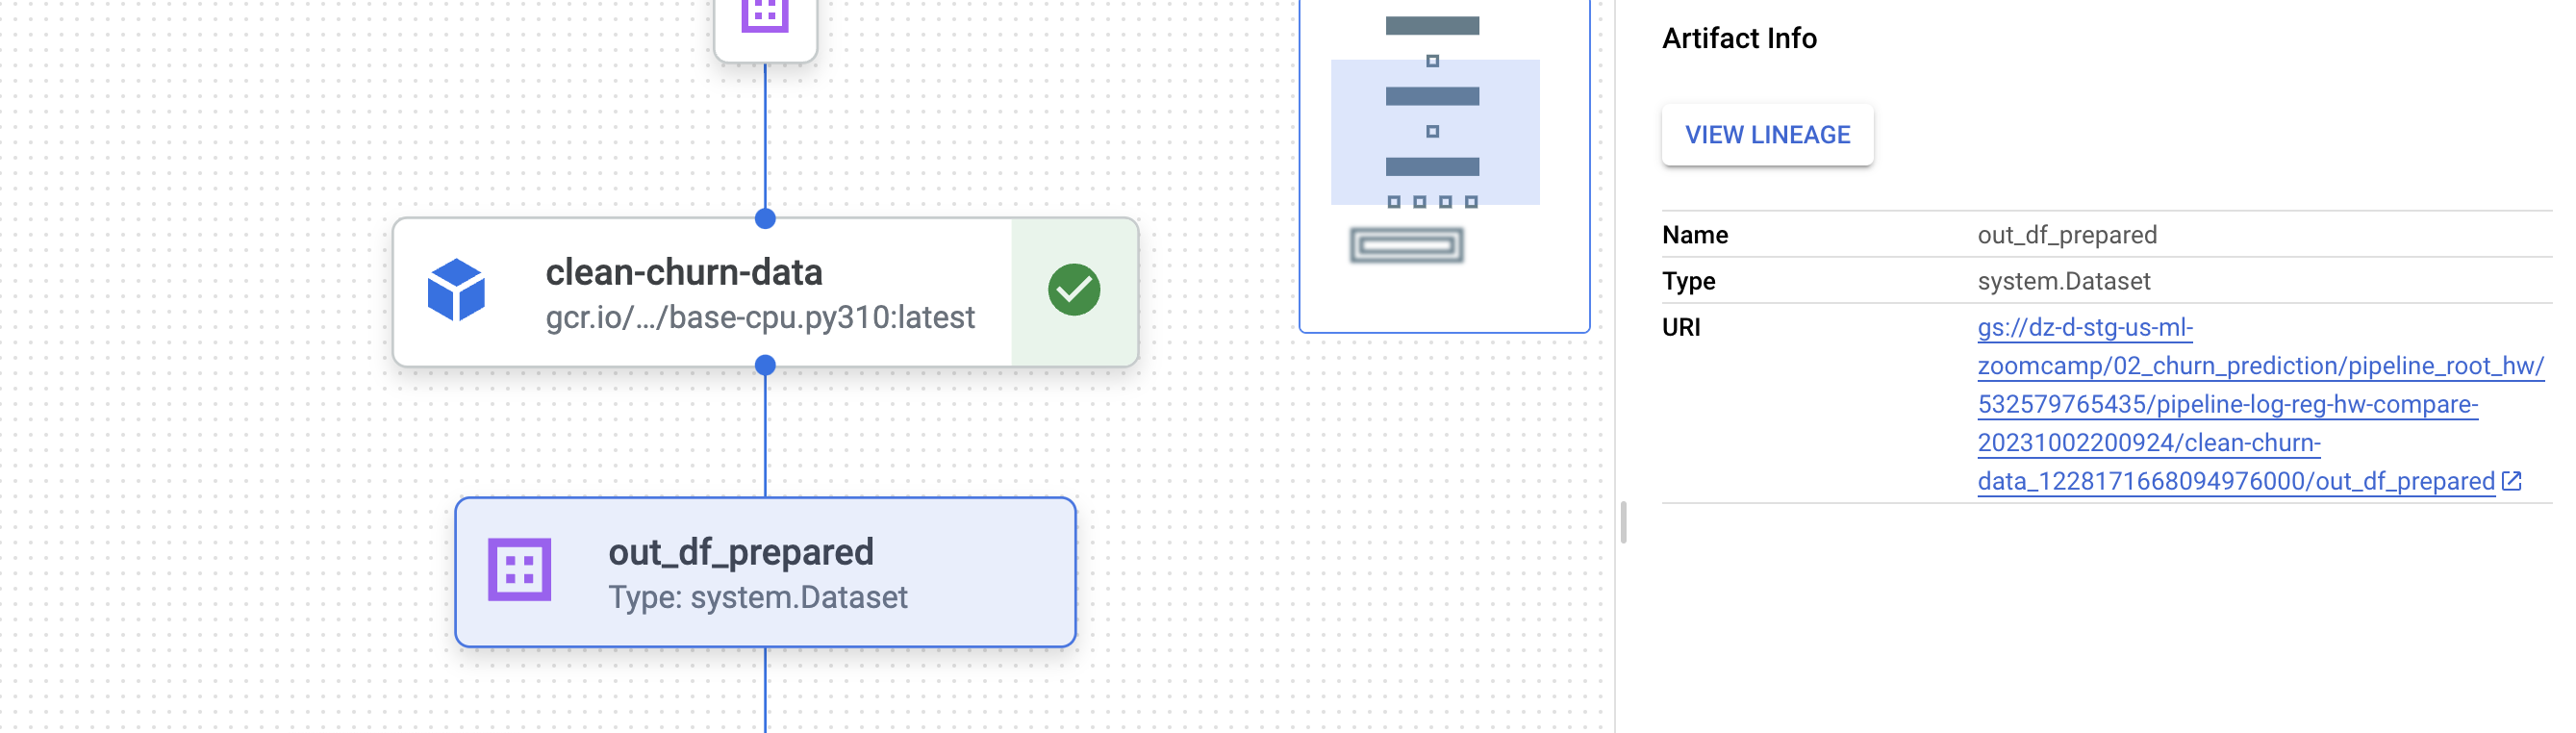

#### Question 1

What is the most frequent observation (mode) for the column `transmission_type`?

- `AUTOMATIC` ✅
- `MANUAL`
- `AUTOMATED_MANUAL`
- `DIRECT_DRIVE`

In [ ]:
import pandas as pd
import pickle

gcs_df_prepared = "gs://dz-d-stg-us-ml-zoomcamp/02_churn_prediction/pipeline_root_hw/532579765435/pipeline-log-reg-hw-compare-20231002215536/clean-churn-data_-3755765007032254464/out_df_prepared"
df_prepared = pd.read_pickle(gcs_df_prepared + '.pkl') 

<Axes: xlabel='Transmission Type', ylabel='Count'>

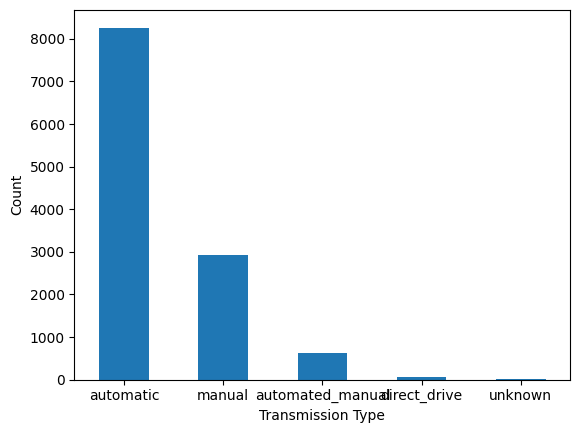

In [ ]:
df_prepared.transmission_type.value_counts().plot(kind='bar', xlabel='Transmission Type', ylabel='Count', rot=0)

#### Question 2

Create the [correlation matrix](https://www.google.com/search?q=correlation+matrix) for the numerical features of your dataset. 
In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

What are the two features that have the biggest correlation in this dataset?

- `engine_hp` and `year`
- `engine_hp` and `engine_cylinders`
- `highway_mpg` and `engine_cylinders`
- `highway_mpg` and `city_mpg`✅

In [ ]:
corrM =df_prepared[numerical].corr()
corrM

,engine_hp,engine_cylinders,highway_mpg,city_mpg
engine_hp,1.000000,0.774851,-0.415707,-0.424918
engine_cylinders,0.774851,1.000000,-0.614541,-0.587306
highway_mpg,-0.415707,-0.614541,1.000000,0.886829
city_mpg,-0.424918,-0.587306,0.886829,1.000000


### Question 3

* Calculate the mutual information score between `above_average` and other categorical variables in our dataset. 
  Use the training set only.
* Round the scores to 2 decimals using `round(score, 2)`.

Which of these variables has the lowest mutual information score?
  
- `make`
- `model`
- `transmission_type`✅
- `vehicle_style`

In [ ]:
gcs_df_train = "gs://dz-d-stg-us-ml-zoomcamp/02_churn_prediction/pipeline_root_hw/532579765435/pipeline-log-reg-hw-compare-20231002221043/split-data_-8867350584097767424/out_df_train"
df_train = pd.read_pickle(gcs_df_prepared + '.pkl')

In [ ]:
from sklearn.metrics import mutual_info_score

def mutual_info_churn(series):
    return mutual_info_score(df_train.above_average, series)

In [ ]:
round(df_train[categorical].apply(mutual_info_churn).sort_values(ascending=False),2)

model                0.46
make                 0.24
vehicle_style        0.08
year                 0.07
transmission_type    0.02
dtype: float64

In [ ]:
gcs_df_accuracy = "gs://dz-d-stg-us-ml-zoomcamp/02_churn_prediction/pipeline_root_hw/532579765435/pipeline-log-reg-hw-compare-20231002223134/compare-models_-15525516501057536/out_df_accuracy"
df_accuracy = pd.read_pickle(gcs_df_accuracy + '.pkl')

In [ ]:
df_accuracy.sort_values(by = "accuracy", ascending = False)

,accuracy,key_feature
1,0.95,engine_cylinders
4,0.95,make
6,0.95,year
8,0.95,vehicle_style
0,0.94,engine_hp
2,0.94,highway_mpg
3,0.94,city_mpg
7,0.94,transmission_type
9,0.94,all
5,0.93,model


### Question 4

What accuracy did you get from training with all features?

- 0.60
- 0.72
- 0.84
- 0.95✅

### Question 5 

* Let's find the least useful feature using the *feature elimination* technique.
* Train a model with all these features (using the same parameters as in Q4).
* Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
* For each feature, calculate the difference between the original accuracy and the accuracy without the feature. 

Which of following feature has the smallest difference?

- `year`✅
- `engine_hp`
- `transmission_type`
- `city_mpg`

> **Note**: the difference doesn't have to be positive